In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%ls

drive/  sample_data/


In [0]:
%cd drive/My\ Drive/Colab\ Notebooks/FSI/Toxic\ Comments/

/content/drive/My Drive/Colab Notebooks/FSI/Toxic Comments


In [0]:
!python

Python 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0] on linux
Type "help", "copyright", "credits" or "license" for more information.
>>> import nltk
>>> nltk.download()
NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all
       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Unzipping corpora/biocreative_ppi.zip.
       | Downloading package brown to /root/nltk_data...
       |   Unzipping corpora/brown.zip.
       | Downloading package brown_tei to /root/nltk_data...
       |   Unzipping corpora/brow

# **Toxic Comment**

Será utilizado a base de dados *Toxic Comment Classification*, disponibilizada no Kaggle.

Essa base possui 6 classes e 159571 exemplos de amostras.

Classes:


*   toxic
*   severe toxic
*   obscene
*   threat
*   insult
*   identity hate



## **Implementação**

Primeiramente importamos as bibliotecas necessárias para todo o programa.

In [0]:
import re
from time import time
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.linear_model import Perceptron
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import matplotlib.gridspec as gridspec

%matplotlib inline

Carregamos a base de dados:

In [0]:
data = pd.read_csv("train.csv")
df = pd.DataFrame(data)

In [0]:
df.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d aww he matches this background colour i am s...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i am really not trying to edit war it ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i can not make any real suggestions on im...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


Função para pré-processamento dos comentários:

*   Conversão dos comentários para letras minúsculas;
*   Substituição de abreviações comuns para escrita completa;
*   Remoção de pontuação. 


In [0]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [0]:
df['comment_text'] = df['comment_text'].map(lambda com : clean_text(com))

*   Exemplo de comentário:







> ![alt text](https://drive.google.com/uc?id=1QaBnoIEaf1Dv4YpgknH8NKd-GdHhZXCr)



*   Comentário após pré-processamento:



> ![alt text](https://drive.google.com/uc?id=1el3AwD1pu8T9FfBaQx_TXAe-kZ80S1vx)



Conversão do dataframe para o formato de série e separação das informações de comentários e rótulos em variáveis diferentes:

In [0]:
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
comment = ['comment_text']

dataset_serie, _ = train_test_split(df, random_state=42, test_size=0.0001, shuffle=True)

dataset_serie_comment = dataset_serie.comment_text
dataset_serie_categories = dataset_serie[categories]

print(dataset_serie_comment.head(), "\n\n")
print(dataset_serie_categories.head())

30404    ed poor i should not have to check his edit hi...
12000    that is not a list of official names of offici...
41916    yes merge chamin and cholent are one and the s...
38974    26 july 2014 utc there are a number of key wor...
70064    i am just going to state as i have observed th...
Name: comment_text, dtype: object 


       toxic  severe_toxic  obscene  threat  insult  identity_hate
30404      0             0        0       0       0              0
12000      0             0        0       0       0              0
41916      0             0        0       0       0              0
38974      0             0        0       0       0              0
70064      0             0        0       0       0              0


Extração dos descritores dos comentários:

In [0]:
vectorizer = TfidfVectorizer(stop_words=stop_words)
comment_vec = vectorizer.fit_transform(dataset_serie_comment)

Divisão do dataset entre informações de treinamento e teste:

In [0]:
tam_data,j = comment_vec.shape
limite_train = round(tam_data*0.66)

In [0]:
data_train = comment_vec[0:limite_train,]
data_test = comment_vec[limite_train:,]
label_train = dataset_serie_categories.iloc[0:limite_train,]
label_test = dataset_serie_categories.iloc[limite_train:,]

Função para plotar Matrix de confusão:

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes, title):
    # Calcula acurácia
    acc = accuracy_score(y_true, y_pred)

    plt.figure(figsize=(10,10))

    for i in range(6):
      # Constroi matriz de confusão
      cm = multilabel_confusion_matrix(y_true, y_pred)[i]
      cm = normalize(cm, axis=1, norm='l1')
      cm_df = pd.DataFrame(cm, index = classes, columns = classes)
      plt.subplot(3,3,i+1)     
      sns.heatmap(cm_df, annot=True, cmap="YlGnBu")
      plt.title(title[i])
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

### Função para realização da classificação a partir do MultiOutput Classifier




In [0]:
def classification(clf,name):
  print('_' * 80)
  print("Training: ", name)
  t0 = time()

  # Realiza o fit do classificador
  trainning = MultiOutputClassifier(clf)
  trainning.fit(data_train, label_train)
                        
  train_time = time() - t0                  
  print("train time: %0.3fs" % train_time)

  t0 = time()

  #Realiza a predição
  pred = trainning.predict(data_test)

  test_time = time() - t0

  # Imprime acurácia da classificação
  print("test time:  %0.3fs" % test_time)
  print('Test accuracy is {}'.format(accuracy_score(label_test, pred)))
  
  # Matriz de confusão para cada rótulo
  
  plot_confusion_matrix(label_test, pred, classes=[0,1], title=categories)

### **Resultados**

________________________________________________________________________________
Training:  LinearSVC
train time: 2.467s
test time:  0.034s
Test accuracy is 0.918155173367251


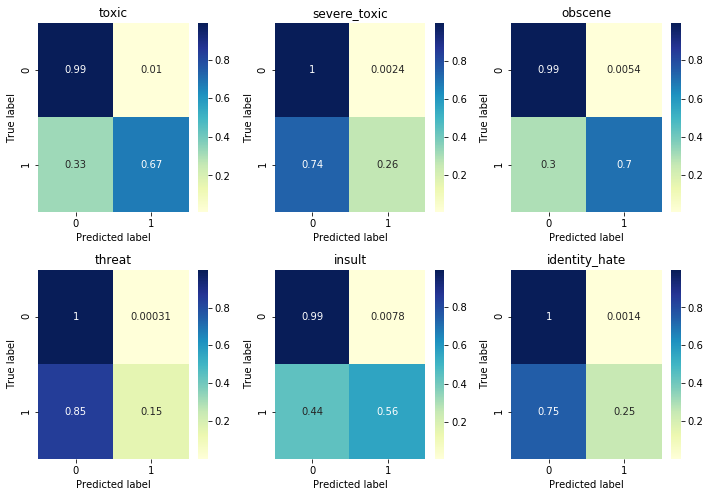

________________________________________________________________________________
Training:  LinearSVC Balanced (com ajuste de pesos das classes)
train time: 14.812s
test time:  0.034s
Test accuracy is 0.8979889030212539


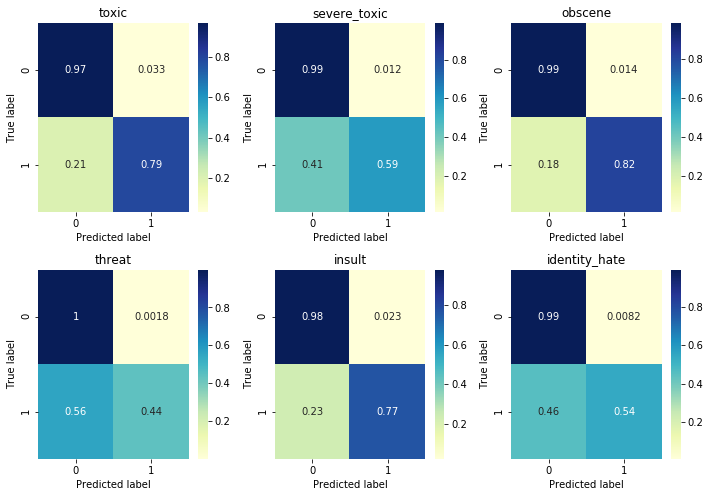

________________________________________________________________________________
Training:  Perceptron
train time: 1.183s
test time:  0.035s
Test accuracy is 0.8960718169920183


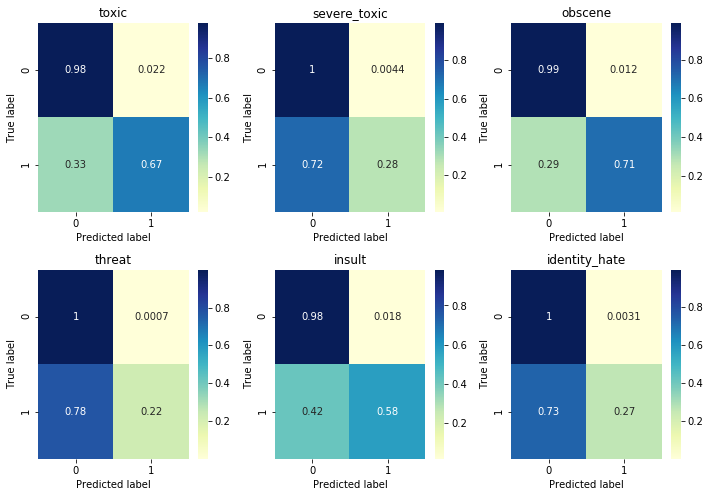

In [0]:
for clf, name in ((LinearSVC(),'LinearSVC'),(LinearSVC(class_weight='balanced',max_iter=3000),'LinearSVC Balanced (com ajuste de pesos das classes)'), (Perceptron(),'Perceptron')):
  classification(clf,name)


### Analise



*   Quantidade de comentários em cada categoria



![alt text](https://drive.google.com/uc?id=1XkoBaH-tAO2Qe36DroO0RL8djuBqOZBK)



*   Comentários com multiplos rótulos



![alt text](https://drive.google.com/uc?id=1IuiK4OInBDmQMVFlArDaX6bLZaTSJHrv)